# Data Augmentation on Sample from Dataset

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader

### Load Data

In [2]:
# Set seed for PyTorch random number generation to create reproducible results
torch.manual_seed(5)

In [3]:
# Convert PIL Image to tensor
transforms_list = transforms.Compose([
    # Convert PIL Image to tensor and scale to [0, 1]
    transforms.PILToTensor(),
    # Perform max normalization (pixel value/known max value)
    # transforms.Normalize(0, 255, inplace=True),
    
])

# Transformations to apply to inputs, where one is randomly chosen and applied per image
augmentations = transforms.RandomChoice([
    # Rotate by a random amount within -2 to 2 degrees
    transforms.RandomRotation(degrees=2, fill=255), 
    # Translate horizontally by a random percentage between 0 and 20% and
    # vertically by a random percentage between 0% and 10%
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), fill=255), 
    # Horizontally flips the image
    transforms.RandomHorizontalFlip(p=1)
])

In [4]:
# Helper function to generate annotation file containing image filename, image label
def get_img_labels(img_dir):
    labels = ''.join([f + ",0\n" for f in os.listdir(img_dir + r"\normal")])
    labels += ''.join([f + ",1\n" for f in os.listdir(img_dir + r"\abnormal")])
    
    return labels

In [5]:
# Image dataset
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform, augment):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",")
        self.transform = transform
        self.augment = augmentations

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        # Generate image filepath
        subfolder = ''
        if(self.img_labels.iloc[idx, 1] == 0):
            subfolder = r'\normal'
        else:
            subfolder = r'\abnormal'
        img_path = self.img_dir + subfolder + "\\" + self.img_labels.iloc[idx, 0]
        
        # Read image as greyscale
        image = Image.open(img_path).convert("RGB")
        
        image = self.transform(image)
        image = self.augment(image)
        label = self.img_labels.iloc[idx, 1]
        return image, label

In [6]:
# Amount of images to pass through the model in one minibatch
batch_size = 9

In [7]:
# Dataset and dataloader for training data
trainset = CustomDataset(img_dir=r"dataset-sample\train", transform=transforms_list, augment=augmentations)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

Classes: 1 0 0 1 1 1 0 1 0


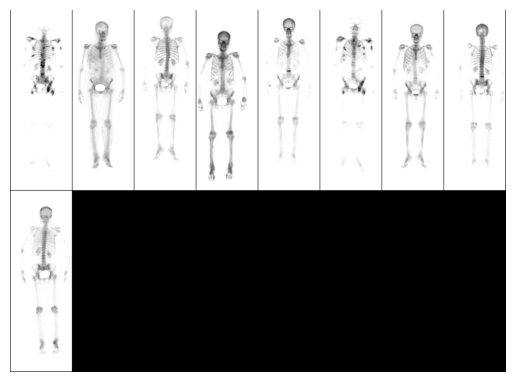

In [8]:
# Show random images from training data and their ground truth classes
dataiter = iter(trainloader)
images, labels = next(dataiter)

plt.axis('off')
plt.imshow(make_grid(images).permute(1,2,0))
print("Classes: " + ' '.join(f'{labels[j]}' for j in range(len(labels))))